In [1]:
import sys

if "google.colab" in sys.modules:
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 12.46 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 179 packages in 11.79s
Prepared 41 packages in 53.69s
Uninstalled 31 packages in 1.24s
Installed 41 packages in 520ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + 

# 데이터 준비

In [2]:
import requests
import zipfile
import tarfile

# 다운로드
url = "https://archive.ics.uci.edu/static/public/385/kasandr.zip"
response = requests.get(url)
with open("kasandr.zip", "wb") as file:
    file.write(response.content)

# kasandr.zip 파일 해제
with zipfile.ZipFile("kasandr.zip", "r") as zip_ref:
    zip_ref.extractall("./kasandr_data")

# de.tar.bz2 파일 해제
with tarfile.open("./kasandr_data/de.tar.bz2", "r:bz2") as tar:
    tar.extractall("./kasandr_data", filter='data')

In [3]:
import pandas as pd

file_path = "/content/kasandr_data/de/train_de.csv"
df = pd.read_csv(file_path, delimiter='\t')
df.head(3)

,userid,offerid,countrycode,category,merchant,utcdate,rating
0,fa937b779184527f12e2d71c711e6411236d1ab59f8597...,c5f63750c2b5b0166e55511ee878b7a3,de,100020213,f3c93baa0cf4430849611cedb3a40ec4094d1d370be841...,2016-06-14 17:28:47.0,0
1,f6c8958b9bc2d6033ff4c1cc0a03e9ab96df4bcc528913...,19754ec121b3a99fff3967646942de67,de,100020213,21a509189fb0875c3732590121ff3fc86da770b0628c18...,2016-06-14 17:28:48.0,0
2,02fe7ccf1de19a387afc8a11d08852ffd2b4dabaed4e2d...,5ac4398e4d8ad4167a57b43e9c724b18,de,125801,b042951fdb45ddef8ba6075ced0e5885bc2fa4c4470bf7...,2016-06-14 17:28:50.0,0


In [4]:
# Parquet 파일로 저장
parquet_file_path = "./kasandr_data/de/train_de.parquet"
df.to_parquet(parquet_file_path, engine="pyarrow", index=False)

print(f"Parquet 파일이 저장되었습니다: {parquet_file_path}")

Parquet 파일이 저장되었습니다: ./kasandr_data/de/train_de.parquet


# 세션 다시 시작

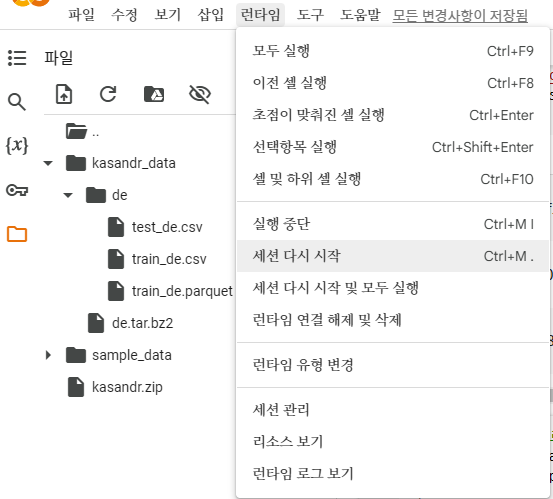

In [5]:
import os
import pandas as pd

# Parquet 파일 경로 지정
parquet_file_path = "./kasandr_data/de/train_de.parquet"

# Parquet 파일 불러오기
df_parquet = pd.read_parquet(parquet_file_path)

# Parquet 파일 크기 확인
parquet_file_size = os.path.getsize(parquet_file_path)

# 파일 크기를 MB 단위로 변환
parquet_file_size_mb = parquet_file_size / (1024 * 1024)

print(f"Parquet 파일 크기: {parquet_file_size_mb:.2f} MB")
print(df_parquet.head(3))

Parquet 파일 크기: 1211.30 MB
                                              userid  \
0  fa937b779184527f12e2d71c711e6411236d1ab59f8597...   
1  f6c8958b9bc2d6033ff4c1cc0a03e9ab96df4bcc528913...   
2  02fe7ccf1de19a387afc8a11d08852ffd2b4dabaed4e2d...   

                            offerid countrycode   category  \
0  c5f63750c2b5b0166e55511ee878b7a3          de  100020213   
1  19754ec121b3a99fff3967646942de67          de  100020213   
2  5ac4398e4d8ad4167a57b43e9c724b18          de     125801   

                                            merchant                utcdate  \
0  f3c93baa0cf4430849611cedb3a40ec4094d1d370be841...  2016-06-14 17:28:47.0   
1  21a509189fb0875c3732590121ff3fc86da770b0628c18...  2016-06-14 17:28:48.0   
2  b042951fdb45ddef8ba6075ced0e5885bc2fa4c4470bf7...  2016-06-14 17:28:50.0   

   rating  
0       0  
1       0  
2       0  


# XGBoost CPU

In [5]:
%%time

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb


# Parquet 파일 경로
parquet_file_path = "./kasandr_data/de/train_de.parquet"

# 데이터 불러오기
df = pd.read_parquet(parquet_file_path)

# 날짜 컬럼 'utcdate'를 타임스탬프 형식으로 변환
df['utcdate'] = pd.to_datetime(df['utcdate']) # df['utcdate']를 datetime 객체로 변환
df['utcdate'] = df['utcdate'].astype(int) / 10**9  # 초 단위로 변환

# 범주형 컬럼을 scikit-learn LabelEncoder로 변환
label_encoder = LabelEncoder()
for column in ['userid', 'offerid', 'countrycode', 'category', 'merchant']:
    df[column] = label_encoder.fit_transform(df[column])

# 특징(X)과 레이블(y) 분리
X = df.drop('rating', axis=1)  # rating 열은 레이블이므로 제외
y = df['rating']  # rating 열을 레이블로 지정

# 훈련 데이터 80%, 검증 데이터 20%로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# DMatrix 생성 (XGBoost에서 데이터를 효율적으로 처리하는 데이터 구조)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# XGBoost CPU 모델 초기화 및 학습
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'cpu'
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# 테스트 데이터 확률 예측
y_test_pred = xgb_model.predict(dtest)

# 확률이 0.5 이상이면 1, 미만이면 0으로 변환
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# 모델 평가
xgb_cpu_accuracy = accuracy_score(y_test, y_test_pred_binary)
xgb_cpu_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print(f'XGBoost CPU Classifier 정확도: {xgb_cpu_accuracy}')
print('XGBoost CPU Classifier 혼동행렬:')
print(xgb_cpu_conf_matrix)

XGBoost CPU Classifier 정확도: 0.9635263355868706
XGBoost CPU Classifier 혼동행렬:
[[3020881    6278]
 [ 109305   32480]]
CPU times: user 3min 25s, sys: 10.2 s, total: 3min 35s
Wall time: 2min 38s


# XGBoost GPU

In [6]:
import gc

# 메모리 정리: 이전 학습에 사용된 대용량 객체 제거
del df, X, y, X_train, X_test, y_train, y_test, dtrain, dtest
gc.collect()

30

In [7]:
%%time

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb


# Parquet 파일 경로
parquet_file_path = "./kasandr_data/de/train_de.parquet"

# 데이터 불러오기
df = pd.read_parquet(parquet_file_path)

# 날짜 컬럼 'utcdate'를 타임스탬프 형식으로 변환
df['utcdate'] = pd.to_datetime(df['utcdate']) # df['utcdate']를 datetime 객체로 변환
df['utcdate'] = df['utcdate'].astype(int) / 10**9  # 초 단위로 변환

# 범주형 컬럼을 scikit-learn LabelEncoder로 변환
label_encoder = LabelEncoder()
for column in ['userid', 'offerid', 'countrycode', 'category', 'merchant']:
    df[column] = label_encoder.fit_transform(df[column])

# 특징(X)과 레이블(y) 분리
X = df.drop('rating', axis=1)  # rating 열은 레이블이므로 제외
y = df['rating']  # rating 열을 레이블로 지정

# 훈련 데이터 80%, 검증 데이터 20%로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# DMatrix 생성 (XGBoost에서 데이터를 효율적으로 처리하는 데이터 구조)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# XGBoost GPU 모델 초기화 및 학습
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'cuda'
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# 테스트 데이터 확률 예측
y_test_pred = xgb_model.predict(dtest)

# 확률이 0.5 이상이면 1, 미만이면 0으로 변환
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# 모델 평가
xgb_gpu_accuracy = accuracy_score(y_test, y_test_pred_binary)
xgb_gpu_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print(f'XGBoost GPU Classifier 정확도: {xgb_gpu_accuracy}')
print('XGBoost GPU Classifier 혼동행렬:')
print(xgb_gpu_conf_matrix)

XGBoost GPU Classifier 정확도: 0.9638267511196159
XGBoost GPU Classifier 혼동행렬:
[[3021212    5947]
 [ 108684   33101]]
CPU times: user 1min 9s, sys: 8.47 s, total: 1min 18s
Wall time: 1min 20s


# RAPIDS와 XGBoost GPU

In [8]:
import gc

# 메모리 정리: 이전 학습에 사용된 대용량 객체 제거
del df, X, y, X_train, X_test, y_train, y_test, dtrain, dtest
gc.collect()

47

In [9]:
%%time

import xgboost as xgb

import cupy as cp
import cudf
import cuml

from cuml.preprocessing import LabelEncoder
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score, confusion_matrix


# Parquet 파일 경로
parquet_file_path = "./kasandr_data/de/train_de.parquet"

# 데이터 불러오기 (cudf로 변경)
df = cudf.read_parquet(parquet_file_path)

# 날짜 컬럼 'utcdate'를 타임스탬프 형식으로 변환
df['utcdate'] = cudf.to_datetime(df['utcdate']) # df['utcdate']를 datetime 객체로 변환
df['utcdate'] = df['utcdate'].astype('int64') // 10**9  # 초 단위로 변환

# 범주형 컬럼을 cuML LabelEncoder로 변환
label_encoder = LabelEncoder()
for column in ['userid', 'offerid', 'countrycode', 'category', 'merchant']:
    df[column] = label_encoder.fit_transform(df[column])

# 특징(X)과 레이블(y) 분리
X = df.drop('rating', axis=1)  # rating 열은 레이블이므로 제외
y = df['rating']  # rating 열을 레이블로 지정

# cuDF에서 train_test_split 사용을 위한 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost DMatrix로 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# XGBoost GPU 모델 초기화 및 학습
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'cuda',
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# 예측 (확률 값)
y_test_pred = xgb_model.predict(dtest)

# 확률 값(0~1)을 이진 클래스(0, 1)로 변환
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# 모델 평가
xgb_rapids_accuracy = accuracy_score(y_test, y_test_pred_binary)
xgb_rapids_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print(f'RAPIDS + XGBoost GPU Classifier 정확도: {xgb_rapids_accuracy}')
print('RAPIDS + XGBoost GPU Classifier 혼동행렬:')
print(xgb_rapids_conf_matrix)

RAPIDS + XGBoost GPU Classifier 정확도: 0.963802441381874
RAPIDS + XGBoost GPU Classifier 혼동행렬:
[[3020992    6166]
 [ 108542   33243]]
CPU times: user 19.5 s, sys: 2.41 s, total: 22 s
Wall time: 32.6 s
